In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [3]:
dataset = np.loadtxt("dataset.csv", delimiter=',', dtype = np.float32)

In [4]:
len(dataset)

999913

In [5]:
training_dataset = dataset[0:900000]
testing_dataset = dataset[900001:]

In [6]:
class dataset (Dataset):
    def __init__(self,data,label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx],self.label[idx]
data_set = dataset(training_dataset[:,:-1],training_dataset[:,-1])
dataloader = DataLoader(data_set,batch_size=10000,shuffle = True)

In [18]:
#creating the model for prediction part
class Prediction_Model(nn.Module):
    def __init__(self):
        super(Prediction_Model,self).__init__()
        self.l1 = nn.Linear(9,20)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(20,10)
        self.l3 = nn.Linear(10,1)
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = Prediction_Model()

In [19]:
device = torch.device("cuda")
model = model.to(device)

In [20]:
#training area and getting validation curve
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr = 0.001)
training_loss = []
testing_loss = []
epoch = []
for e in range(20):
    net_training_loss = 0.0
    net_iteration = 0
    for i,(data,label) in enumerate(dataloader):
        label = label.view(10000,1)
        optim.zero_grad()
        data = data.to(device)
        label = label.to(device)
        prediction = model.forward(data)
        l = loss(prediction,label)
        l.backward()
        optim.step()
        net_training_loss += l
        net_iteration += 1
    trainingloss = net_training_loss/net_iteration
    training_loss.append(trainingloss)
    net_testing_loss = 0.0
    net_iteration = 0
    for data_for_testing in testing_dataset:
        dt,lt = data_for_testing[:-1], data_for_testing[-1]
        prediction = model.forward(torch.from_numpy(dt).view(1,9).to(device))
        l = abs(lt.item() - prediction.item())
        net_testing_loss += l
        net_iteration += 1
    testingloss = net_testing_loss/net_iteration
    testing_loss.append(testingloss)
    epoch.append(e+1)
    if((testingloss-trainingloss)/trainingloss > 0.5):
      print('overtrained')
      break
    print(f"epoch : {e+1} training loss : {trainingloss} testing loss : {testingloss}")



epoch : 1 training loss : 6.599350929260254 testing loss : 0.9998264186214687
epoch : 2 training loss : 1.4451292753219604 testing loss : 0.9519779302409261
epoch : 3 training loss : 1.2998615503311157 testing loss : 0.9012227431199548
epoch : 4 training loss : 1.1487154960632324 testing loss : 0.8462470549177983
epoch : 5 training loss : 1.0229151248931885 testing loss : 0.8064680815674654
epoch : 6 training loss : 0.9231826066970825 testing loss : 0.7595710313137853
epoch : 7 training loss : 0.7955646514892578 testing loss : 0.6942424985717498
epoch : 8 training loss : 0.6391938924789429 testing loss : 0.6061949507771511
epoch : 9 training loss : 0.48274630308151245 testing loss : 0.5190107022276095
epoch : 10 training loss : 0.36697226762771606 testing loss : 0.4575035668735715
epoch : 11 training loss : 0.30692434310913086 testing loss : 0.42851929506935665
epoch : 12 training loss : 0.2812122702598572 testing loss : 0.4204715909614935
overtrained


In [ ]:
#testing dataset
import random
dt,lt = testing_dataset[:,:-1],testing_dataset[:,-1]
# print(dt.shape,lt.shape)
i = random.randint(0,99900)
print(model.forward_training(torch.from_numpy(dt[i])))
print(lt[i])

tensor([4.8073], grad_fn=<ViewBackward0>)
4.584716


In [ ]:
#saving the model
# torch.save(model,"user_interface/model/agriculture_yield_prediction")
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('user_interface/model/agriculture_yield_prediction.pt')

In [ ]:
# #loading it
# loadmodel = torch.load("user_interface/model/agriculture_yield_prediction")
# loadmodel.eval()
loadmodel = torch.jit.load('user_interface/model/agriculture_yield_prediction.pt')
loadmodel.eval()

RecursiveScriptModule(
  original_name=Prediction_Model
  (l1): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (l2): RecursiveScriptModule(original_name=Linear)
  (l3): RecursiveScriptModule(original_name=Linear)
)

In [ ]:
import random
dt,lt = testing_dataset[:,:-1],testing_dataset[:,-1]
# print(dt.shape,lt.shape)
i = random.randint(0,99900)
print(dt[i])
print(loadmodel.forward(torch.from_numpy(dt[i])))
print(lt[i])

[  1.         0.         1.       745.2252    21.727076   1.
   1.         0.       102.      ]
tensor([6.9891], grad_fn=<ViewBackward0>)
6.2779455


In [ ]:
#model testing
import matplotlib.pyplot as plt

In [ ]:
total_loss = 0.0
total_iteration = 0.0
loss = []
iteration = []
for data_for_testing in testing_dataset:
    dt,lt = data_for_testing[:-1], data_for_testing[-1]
    prediction = loadmodel.forward(torch.from_numpy(dt).view(1,9))
    l = abs(lt.item() - prediction.item())
    loss.append(l)
    total_loss += l
    total_iteration += 1
    iteration.append(total_iteration)

In [ ]:
#average loss
print(total_loss)
print(total_iteration)
print(total_loss/total_iteration)

40697.914004597726
99912.0
0.40733759713145296


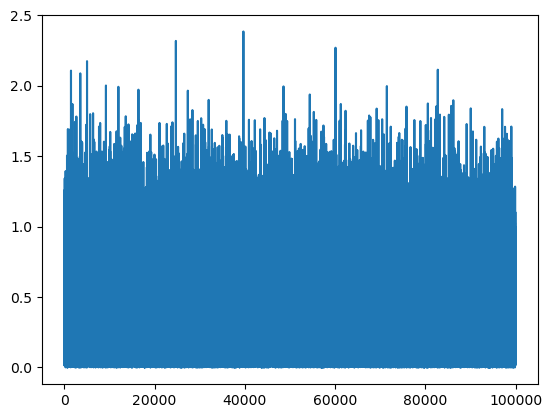

In [ ]:
#generation graph
plt.plot(iteration,loss)
plt.show()

In [ ]:
#graph by averaging 1000 value
avg_loss = []
itera = []
for i in range(100):
    avg = 0.0
    for j in range(1000):
        avg += loss[i+j]
    avg_loss.append(avg/1000)
    itera.append(i)


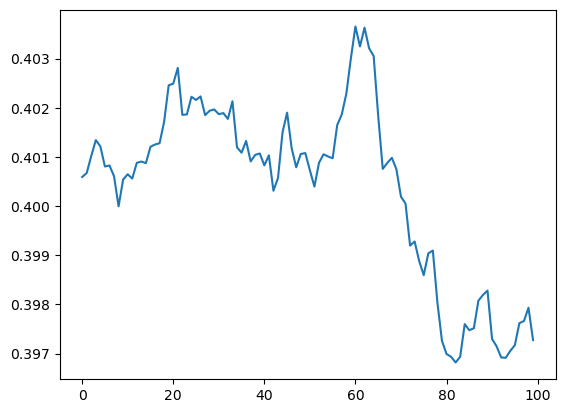

In [ ]:
#plottiong it
plt.plot(itera,avg_loss)

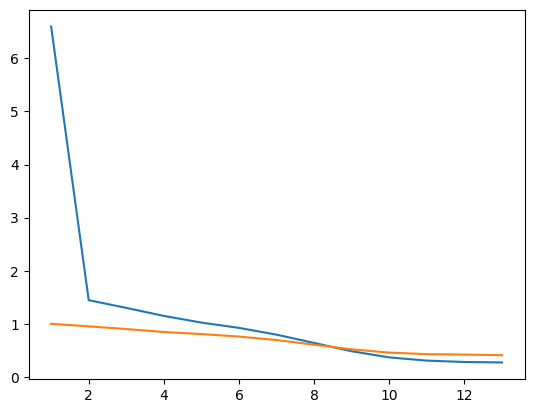

In [21]:
import matplotlib.pyplot as plt
for i in range(epoch[-1]):
    training_loss[i] = training_loss[i].to(torch.device("cpu")).detach().numpy()
plt.plot(epoch,training_loss)
plt.plot(epoch,testing_loss)
plt.show()

In [ ]:
script = torch.jit.script(model)
script.save("agriculture_yield.pt")

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [ ]:
model = DecisionTreeRegressor(max_depth=10)

In [24]:
dataset = np.loadtxt("dataset.csv",dtype=np.float32,delimiter=',')

In [25]:
x_train = dataset[:900000, :-1]
y_train = dataset[:900000, -1]

In [26]:
model.fit(x_train,y_train)

RandomForestRegressor(max_depth=9, n_estimators=10)

In [27]:
x_test = dataset[900000:, :-1]
y_test = dataset[900000:, -1]

In [28]:
model.score(x_test,y_test)

0.9126390635478924

In [ ]:
y_pred = loadmodel.predict(x_test)
loss = np.mean((y_pred-y_test)**2)
print(loss)

0.2507545960646856


In [22]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, max_depth=9)

In [ ]:
import joblib
joblib.dump(model,"agricultural_yield_prediction.rn")

['agricultural_yield_prediction.rn']

In [ ]:
loadmodel = joblib.load("agricultural_yield_prediction.rn")

In [ ]:
#for crop price prediction

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [ ]:
dataset = np.loadtxt("dataset.csv", delimiter=',', dtype = np.float32)

In [ ]:
len(dataset)

4452

In [ ]:
training_dataset = dataset[0:4000]
testing_dataset = dataset[4000:]

In [ ]:
class dataset (Dataset):
    def __init__(self,data,label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx],self.label[idx]
data_set = dataset(training_dataset[:,:-1],training_dataset[:,-1])
dataloader = DataLoader(data_set,batch_size=1000,shuffle = True)

In [ ]:
#creating the model for prediction part
class Prediction_Model(nn.Module):
    def __init__(self):
        super(Prediction_Model,self).__init__()
        self.l1 = nn.Linear(2,100)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(100,60)
        self.l3 = nn.Linear(60,60)
        self.l4 = nn.Linear(60,60)
        self.l5 = nn.Linear(60,1)
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        return out

model = Prediction_Model()

In [ ]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
#training area and getting validation curve
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr = 0.001)
training_loss = []
testing_loss = []
epoch = []
e = 0
while True:
    net_training_loss = 0.0
    net_iteration = 0
    for i,(data,label) in enumerate(dataloader):
        label = label.view(1000,1)
        optim.zero_grad()
        data = data.to(device)
        label = label.to(device)
        prediction = model.forward(data)
        l = loss(prediction,label)
        l.backward()
        optim.step()
        net_training_loss += l
        net_iteration += 1
    trainingloss = net_training_loss/net_iteration
    training_loss.append(trainingloss)
    net_testing_loss = 0.0
    net_iteration = 0
    for data_for_testing in testing_dataset:
        dt,lt = data_for_testing[:-1], data_for_testing[-1]
        prediction = model.forward(torch.from_numpy(dt).view(1,2).to(device))
        l = abs(lt.item() - prediction.item())
        net_testing_loss += l
        net_iteration += 1
    testingloss = net_testing_loss/net_iteration
    testing_loss.append(testingloss)
    epoch.append(e+1)
    e = e + 1
    if(trainingloss < testingloss):
      break
    print(f"epoch : {e+1} training loss : {trainingloss} testing loss : {testingloss}")



epoch : 2 training loss : 2531617.5 testing loss : 1100.5271874294674
epoch : 3 training loss : 2527783.75 testing loss : 1098.227044017425
epoch : 4 training loss : 2522592.5 testing loss : 1094.3267154289426
epoch : 5 training loss : 2513596.75 testing loss : 1087.438235303865
epoch : 6 training loss : 2497389.5 testing loss : 1075.3031495367795
epoch : 7 training loss : 2469774.75 testing loss : 1054.7885275872145
epoch : 8 training loss : 2425842.5 testing loss : 1022.9537800218152
epoch : 9 training loss : 2354202.5 testing loss : 979.3769785076116
epoch : 10 training loss : 2253210.0 testing loss : 934.4177642754748
epoch : 11 training loss : 2117510.5 testing loss : 892.9474172549965
epoch : 12 training loss : 1954779.5 testing loss : 870.4443577622945
epoch : 13 training loss : 1805589.0 testing loss : 906.2708033418234
epoch : 14 training loss : 1737887.125 testing loss : 988.854312595013
epoch : 15 training loss : 1766066.25 testing loss : 1023.1825112937826
epoch : 16 traini

KeyboardInterrupt: 

In [ ]:
script = torch.jit.script(model)
script.save("agriculture_yield.pt")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=30)

x_train,y_train = training_dataset[:,:-1],training_dataset[:,-1]
x_test,y_test = testing_dataset[:,:-1],testing_dataset[:,-1]
model.fit(x_train,y_train)

RandomForestRegressor(max_depth=30)

In [ ]:
model.score(x_test,y_test)

0.8934647425328816

In [ ]:
import joblib
joblib.dump(model,"crop_price_prediction.rn")

['crop_price_prediction.rn']